# Importing the Libraries

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
! pip install contractions
import contractions

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/

In [2]:
import os
import re
import string
import emoji
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Loading Data

In [3]:
train_data = pd.read_csv("../input/goemotions/data/train.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])
valid_data = pd.read_csv("../input/goemotions/data/dev.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])
test_data = pd.read_csv("/kaggle/input/goemotions/data/test.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])

In [4]:
train_data.head()

,Text,Class,ID
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    43410 non-null  object
 1   Class   43410 non-null  object
 2   ID      43410 non-null  object
dtypes: object(3)
memory usage: 1017.5+ KB


# Data Preparation

Converting our data to be of format Text -> Labels (one hot type) with Ekman Taxonomy

In [6]:
train_data['Class List'] = train_data['Class'].apply(lambda x: x.split(','))
train_data['Class Length'] = train_data['Class List'].apply(lambda x: len(x))

valid_data['Class List'] = valid_data['Class'].apply(lambda x: x.split(','))
valid_data['Class Length'] = valid_data['Class List'].apply(lambda x: len(x))

test_data['Class List'] = test_data['Class'].apply(lambda x: x.split(','))
test_data['Class Length'] = test_data['Class List'].apply(lambda x: len(x))

In [7]:
train_data.head()

,Text,Class,ID,Class List,Class Length
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1
3,To make her feel threatened,14,ed7ypvh,[14],1
4,Dirty Southern Wankers,3,ed0bdzj,[3],1


In [8]:
train_data["Class Length"].value_counts()

1    36308
2     6541
3      532
4       28
5        1
Name: Class Length, dtype: int64

In [9]:
with open('../input/goemotions/data/ekman_mapping.json') as file:
    ekman_mapping = json.load(file)

In [10]:
ekman_mapping

{'anger': ['anger', 'annoyance', 'disapproval'],
 'disgust': ['disgust'],
 'fear': ['fear', 'nervousness'],
 'joy': ['joy',
  'amusement',
  'approval',
  'excitement',
  'gratitude',
  'love',
  'optimism',
  'relief',
  'pride',
  'admiration',
  'desire',
  'caring'],
 'sadness': ['sadness', 'disappointment', 'embarrassment', 'grief', 'remorse'],
 'surprise': ['surprise', 'realization', 'confusion', 'curiosity']}

In [11]:
emotion_file = open("../input/goemotions/data/emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [12]:
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

In [13]:
train_data['Emotions'] = train_data['Class List'].apply(idx2class)
valid_data['Emotions'] = valid_data['Class List'].apply(idx2class)
test_data['Emotions'] = test_data['Class List'].apply(idx2class)

In [14]:
train_data["Emotions"].value_counts()

[neutral]                                        12823
[admiration]                                      2710
[approval]                                        1873
[gratitude]                                       1857
[amusement]                                       1652
                                                 ...  
[confusion, gratitude, realization]                  1
[disappointment, disapproval, nervousness]           1
[curiosity, disapproval, sadness]                    1
[curiosity, disappointment, remorse, sadness]        1
[admiration, amusement, love]                        1
Name: Emotions, Length: 711, dtype: int64

In [15]:
train_data.head()

,Text,Class,ID,Class List,Class Length,Emotions
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral]
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger]
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear]
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance]


In [16]:
def EmotionMapping(emotion_list):
    map_list = []
    
    for i in emotion_list:
        if i in ekman_mapping['anger']:
            map_list.append('anger')
        if i in ekman_mapping['disgust']:
            map_list.append('disgust')
        if i in ekman_mapping['fear']:
            map_list.append('fear')
        if i in ekman_mapping['joy']:
            map_list.append('joy')
        if i in ekman_mapping['sadness']:
            map_list.append('sadness')
        if i in ekman_mapping['surprise']:
            map_list.append('surprise')
        if i == 'neutral':
            map_list.append('neutral')
            
    return map_list

In [17]:
train_data['Mapped Emotions'] = train_data['Emotions'].apply(EmotionMapping)
valid_data['Mapped Emotions'] = valid_data['Emotions'].apply(EmotionMapping)
test_data['Mapped Emotions'] = test_data['Emotions'].apply(EmotionMapping)

In [18]:
train_data["Mapped Emotions"].value_counts()

[joy]                       12920
[neutral]                   12823
[anger]                      3878
[surprise]                   3553
[joy, joy]                   2129
                            ...  
[fear, sadness, sadness]        1
[joy, anger, disgust]           1
[joy, fear, surprise]           1
[disgust, fear, joy]            1
[joy, anger, joy, joy]          1
Name: Mapped Emotions, Length: 166, dtype: int64

In [19]:
train_data['anger'] = np.zeros((len(train_data),1))
train_data['disgust'] = np.zeros((len(train_data),1))
train_data['fear'] = np.zeros((len(train_data),1))
train_data['joy'] = np.zeros((len(train_data),1))
train_data['sadness'] = np.zeros((len(train_data),1))
train_data['surprise'] = np.zeros((len(train_data),1))
train_data['neutral'] = np.zeros((len(train_data),1))

valid_data['anger'] = np.zeros((len(valid_data),1))
valid_data['disgust'] = np.zeros((len(valid_data),1))
valid_data['fear'] = np.zeros((len(valid_data),1))
valid_data['joy'] = np.zeros((len(valid_data),1))
valid_data['sadness'] = np.zeros((len(valid_data),1))
valid_data['surprise'] = np.zeros((len(valid_data),1))
valid_data['neutral'] = np.zeros((len(valid_data),1))

test_data['anger'] = np.zeros((len(test_data),1))
test_data['disgust'] = np.zeros((len(test_data),1))
test_data['fear'] = np.zeros((len(test_data),1))
test_data['joy'] = np.zeros((len(test_data),1))
test_data['sadness'] = np.zeros((len(test_data),1))
test_data['surprise'] = np.zeros((len(test_data),1))
test_data['neutral'] = np.zeros((len(test_data),1))

In [20]:
for i in ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise','neutral']:
    train_data[i] = train_data['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)
    valid_data[i] = valid_data['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)
    test_data[i] = test_data['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)

In [21]:
train_data.head()

,Text,Class,ID,Class List,Class Length,Emotions,Mapped Emotions,anger,disgust,fear,joy,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral],[neutral],0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral],[neutral],0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger],[anger],1,0,0,0,0,0,0
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear],[fear],0,0,1,0,0,0,0
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance],[anger],1,0,0,0,0,0,0


In [22]:
train_data.drop(["Class", "ID", "Class List", "Class Length", "Emotions", "Mapped Emotions"], axis=1, inplace=True)
valid_data.drop(["Class", "ID", "Class List", "Class Length", "Emotions", "Mapped Emotions"], axis=1, inplace=True)
test_data.drop(["Class", "ID", "Class List", "Class Length", "Emotions", "Mapped Emotions"], axis=1, inplace=True)

# Data PreProcessing

In [23]:
def preprocess(sentence):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    sentence = re.sub('[^A-z]', ' ', sentence)
    negative = ['not', 'neither', 'nor', 'but', 'however', 'although', 'nonetheless', 'despite', 'except',
                        'even though', 'yet']
    stop_words = [z for z in stop_words if z not in negative]
    preprocessed_tokens = [lemmatizer.lemmatize(contractions.fix(temp.lower())) for temp in sentence.split() if temp not in stop_words] #lemmatization
    return ' '.join([x for x in preprocessed_tokens]).strip()

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = preprocess(text)
    return text

In [24]:
train_data['Text'] = train_data['Text'].apply(lambda x: preprocess(x))

In [25]:
valid_data["Text"] = valid_data["Text"].apply(lambda x: preprocess(x))

In [26]:
test_data["Text"] = test_data["Text"].apply(text_preprocessing_pipeline)

In [27]:
pd.Series(train_data["Text"]).str.split().str.len().describe(percentiles=[0.05, 0.97])

count    43410.000000
mean         7.761253
std          3.956936
min          0.000000
5%           2.000000
50%          7.000000
97%         16.000000
max         33.000000
Name: Text, dtype: float64

In [28]:
train_data.head()

,Text,anger,disgust,fear,joy,sadness,surprise,neutral
0,my favourite food anything i cook,0,0,0,0,0,0,1
1,now everyone think he laugh screwing people in...,0,0,0,0,0,0,1
2,why the fuck is bayless isoing,1,0,0,0,0,0,0
3,to make feel threatened,0,0,1,0,0,0,0
4,dirty southern wanker,1,0,0,0,0,0,0


In [29]:
for col in train_data.columns[1:]:
    print(f"{col}:\n",train_data[col].value_counts())
    print("\n")

anger:
 0    37831
1     5579
Name: anger, dtype: int64


disgust:
 0    42617
1      793
Name: disgust, dtype: int64


fear:
 0    42684
1      726
Name: fear, dtype: int64


joy:
 0    26000
1    17410
Name: joy, dtype: int64


sadness:
 0    40147
1     3263
Name: sadness, dtype: int64


surprise:
 0    38043
1     5367
Name: surprise, dtype: int64


neutral:
 0    29191
1    14219
Name: neutral, dtype: int64




# Model_1 (Baseline RoBERTa with Freezed Layers)

In [30]:
train_labels = train_data.drop("Text", axis=1)
valid_labels = valid_data.drop("Text", axis=1)
test_labels = test_data.drop("Text", axis=1)

In [31]:
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

In [32]:
def roberta_encode(data, maximum_length, tokenizer) :
    
    
    input_ids = []
    attention_masks = []
    token_type_ids = []
    for i in range(len(data['Text'])):
        
        encoded = tokenizer.encode_plus(data["Text"].iloc[i],
                                        add_special_tokens=True,
                                        max_length=maximum_length,
                                        pad_to_max_length=True,
                                        return_attention_mask=True,
                                        truncation=True,
                                        return_token_type_ids=True)
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        token_type_ids.append(encoded["token_type_ids"])
        
        
    return np.array(input_ids),np.array(attention_masks),np.array(token_type_ids)

In [33]:
len(train_data.Text)

43410

In [34]:
max_len = max([len(x.split()) for x in train_data['Text']])
train_input_ids,train_attention_masks, train_token_type_ids = roberta_encode(train_data, max_len, tokenizer)
valid_input_ids,valid_attention_masks, valid_token_type_ids = roberta_encode(valid_data, max_len, tokenizer)
test_input_ids,test_attention_masks, test_token_type_ids = roberta_encode(test_data, max_len, tokenizer)

In [35]:
train_input_ids[0], train_attention_masks[0], train_token_type_ids[0]

(array([   0, 4783, 5548,  689,  932,  939, 7142,    2,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [36]:
train_labels.shape, valid_labels.shape, test_labels.shape

((43410, 7), (5426, 7), (5427, 7))

In [37]:
train_input_ids.shape, valid_input_ids.shape

((43410, 33), (5426, 33))

In [38]:
train_attention_masks.shape, valid_attention_masks.shape

((43410, 33), (5426, 33))

In [39]:
train_token_type_ids.shape, valid_token_type_ids.shape

((43410, 33), (5426, 33))

In [40]:
train_data.head(1)

,Text,anger,disgust,fear,joy,sadness,surprise,neutral
0,my favourite food anything i cook,0,0,0,0,0,0,1


In [41]:
def create_model(bert_model, max_len, num_classes=7):
    
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    token_type_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    features = bert_model([input_ids,attention_masks, token_type_ids])
    fc_1 = tf.keras.layers.Dense(256, activation="relu")(features[1])
    dropout_1 = tf.keras.layers.Dropout(0.7)(fc_1)
    output = tf.keras.layers.Dense(num_classes, activation='sigmoid')(dropout_1)
    
    model = tf.keras.models.Model(inputs=[input_ids,attention_masks,token_type_ids], outputs=output)
    
    model.compile(tf.keras.optimizers.Adam(learning_rate=2e-5, weight_decay=1e-6),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision')])
    return model

In [42]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [43]:
from transformers import TFRobertaModel
roberta_model = TFRobertaModel.from_pretrained('roberta-base')
roberta_model.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [44]:
model = create_model(roberta_model, max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]',            

In [45]:
history = model.fit([train_input_ids,train_attention_masks,train_token_type_ids], train_labels,
                    validation_data=([valid_input_ids,valid_attention_masks,valid_token_type_ids], valid_labels),
                    epochs=10,
                    batch_size=256,
                    callbacks=[es])

Epoch 1/10
170/170 [==============================] - 121s 622ms/step - loss: 1.8914 - accuracy: 0.3249 - precision: 0.2458 - val_loss: 1.7009 - val_accuracy: 0.3953 - val_precision: 0.2454
Epoch 2/10
170/170 [==============================] - 113s 665ms/step - loss: 1.7957 - accuracy: 0.3546 - precision: 0.2341 - val_loss: 1.6840 - val_accuracy: 0.3953 - val_precision: 0.2107
Epoch 3/10
170/170 [==============================] - 113s 667ms/step - loss: 1.7792 - accuracy: 0.3601 - precision: 0.2210 - val_loss: 1.6782 - val_accuracy: 0.3953 - val_precision: 0.2107
Epoch 4/10
170/170 [==============================] - 113s 667ms/step - loss: 1.7826 - accuracy: 0.3579 - precision: 0.2122 - val_loss: 1.6768 - val_accuracy: 0.3953 - val_precision: 0.2107
Epoch 5/10
170/170 [==============================] - 113s 667ms/step - loss: 1.7847 - accuracy: 0.3579 - precision: 0.2076 - val_loss: 1.6775 - val_accuracy: 0.3953 - val_precision: 0.2107
Epoch 6/10
170/170 [==============================

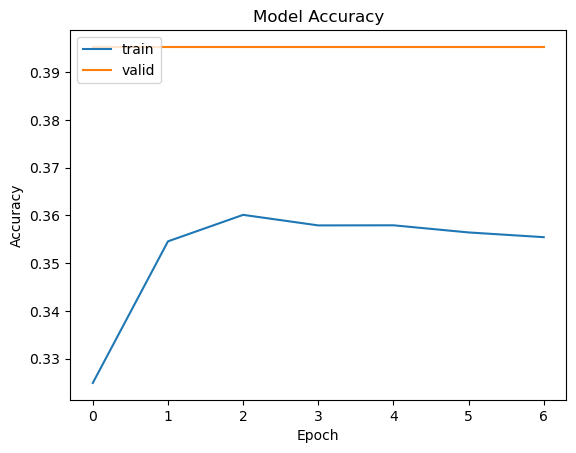

In [46]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

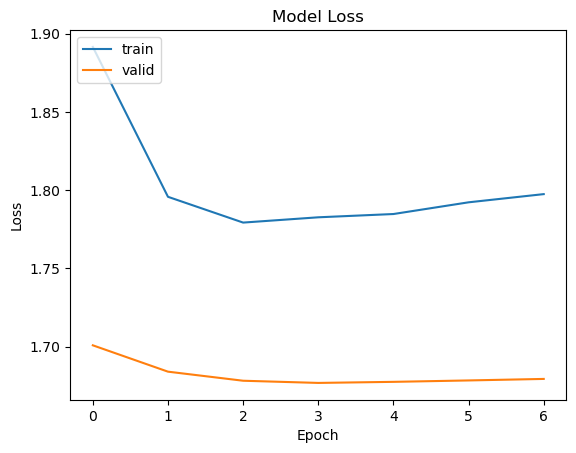

In [47]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

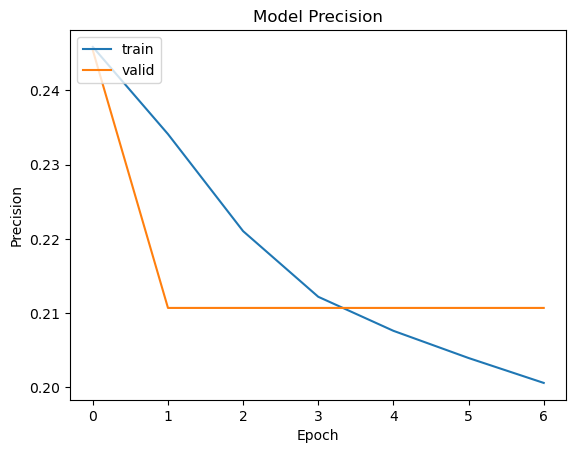

In [48]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [49]:
pred_labels = model.predict([test_input_ids,test_attention_masks, test_token_type_ids])

170/170 [==============================] - 17s 80ms/step


In [50]:
model.evaluate([test_input_ids,test_attention_masks, test_token_type_ids], test_labels)

170/170 [==============================] - 14s 82ms/step - loss: 1.6969 - accuracy: 0.3785 - precision: 0.2091


[1.6969183683395386, 0.3784779906272888, 0.209065780043602]

In [51]:
pred_labels[:5]

array([[0.8505402 , 0.37185892, 0.3036323 , 0.9454149 , 0.7562581 ,
        0.84103066, 0.9318756 ],
       [0.85040593, 0.37527293, 0.30570582, 0.94323885, 0.7514624 ,
        0.8396688 , 0.9329475 ],
       [0.8525762 , 0.3681623 , 0.30430627, 0.9464734 , 0.7525598 ,
        0.84196496, 0.93679464],
       [0.85068   , 0.37916344, 0.3054055 , 0.94568306, 0.7533994 ,
        0.8413771 , 0.93280274],
       [0.85104626, 0.36853617, 0.30651125, 0.94353145, 0.74893445,
        0.8368127 , 0.93474716]], dtype=float32)

In [52]:
def prob(x):
    if x>0.5:
        return 1
    return 0

In [53]:
pred_labels = [list(map(prob,i)) for i in pred_labels]

In [54]:
from sklearn.metrics import label_ranking_average_precision_score
lrap = label_ranking_average_precision_score(pred_labels, test_labels)
print("The Label Ranking Average Precision Score for the Test Set: ", lrap)

The Label Ranking Average Precision Score for the Test Set:  0.772857932559471


In [55]:
from sklearn.metrics import classification_report
target_names = train_data.columns[1:]
print(classification_report(test_labels, pred_labels, target_names=target_names))

              precision    recall  f1-score   support

       anger       0.13      1.00      0.24       726
     disgust       0.00      0.00      0.00       123
        fear       0.00      0.00      0.00        98
         joy       0.39      1.00      0.56      2104
     sadness       0.07      1.00      0.13       379
    surprise       0.12      1.00      0.22       677
     neutral       0.33      1.00      0.50      1787

   micro avg       0.21      0.96      0.34      5894
   macro avg       0.15      0.71      0.23      5894
weighted avg       0.27      0.96      0.41      5894
 samples avg       0.21      0.97      0.34      5894



# Model_2 (RoBERTa with Unfreezed Layers)

In [56]:
es_2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [57]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')
roberta_model.trainable = True

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [58]:
model_2 = create_model(roberta_model, max_len)
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_4[0][0]',                
 odel)                          thPoolingAndCrossAt               'input_5[0][0]',          

In [59]:
history_2 = model_2.fit([train_input_ids,train_attention_masks,train_token_type_ids], train_labels,
                    validation_data=([valid_input_ids,valid_attention_masks,valid_token_type_ids], valid_labels),
                    epochs=10,
                    batch_size=256,
                    callbacks=[es_2])

Epoch 1/10
170/170 [==============================] - 332s 2s/step - loss: 1.4906 - accuracy: 0.5301 - precision: 0.2052 - val_loss: 1.2054 - val_accuracy: 0.6452 - val_precision: 0.1917
Epoch 2/10
170/170 [==============================] - 280s 2s/step - loss: 1.3435 - accuracy: 0.6097 - precision: 0.1863 - val_loss: 1.1510 - val_accuracy: 0.6598 - val_precision: 0.1831
Epoch 3/10
170/170 [==============================] - 280s 2s/step - loss: 1.3759 - accuracy: 0.6195 - precision: 0.1816 - val_loss: 1.2042 - val_accuracy: 0.6677 - val_precision: 0.1786
Epoch 4/10
170/170 [==============================] - 280s 2s/step - loss: 1.4242 - accuracy: 0.6051 - precision: 0.1793 - val_loss: 1.3094 - val_accuracy: 0.6683 - val_precision: 0.1736
Epoch 5/10
170/170 [==============================] - 280s 2s/step - loss: 1.4867 - accuracy: 0.5423 - precision: 0.1762 - val_loss: 1.4494 - val_accuracy: 0.6111 - val_precision: 0.1664
Epoch 5: early stopping


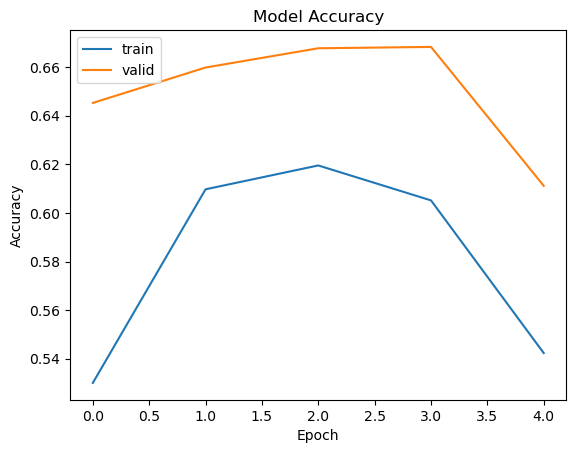

In [60]:
# summarize history for accuracy
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

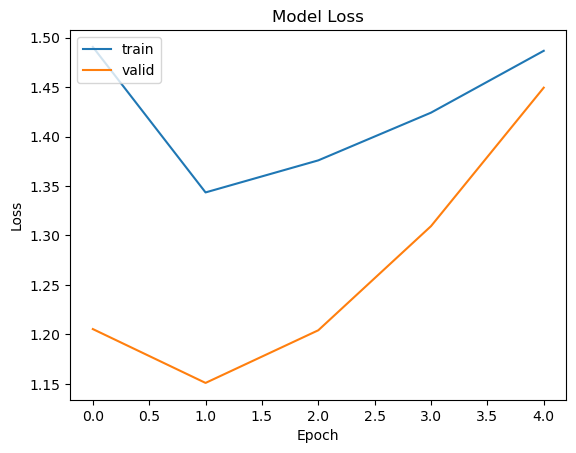

In [61]:
# summarize history for loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

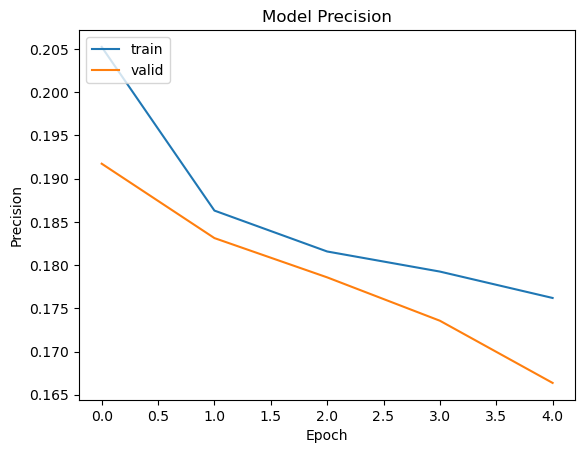

In [62]:
plt.plot(history_2.history['precision'])
plt.plot(history_2.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [63]:
pred_labels_2 = model_2.predict([test_input_ids,test_attention_masks, test_token_type_ids])

170/170 [==============================] - 18s 80ms/step


In [64]:
pred_labels_2[:5]

array([[0.9999939 , 0.88740534, 0.9938433 , 1.        , 1.        ,
        0.9999995 , 0.9999989 ],
       [0.9999845 , 0.999726  , 0.9992594 , 0.9999982 , 0.9996971 ,
        0.9998124 , 0.99860245],
       [0.99999964, 0.52925086, 0.97386634, 1.        , 0.9998599 ,
        1.        , 1.        ],
       [0.9999995 , 0.69783676, 0.98826283, 1.        , 0.99997056,
        1.        , 1.        ],
       [0.9999428 , 0.87729585, 0.7852316 , 0.99981374, 0.99998665,
        0.9998497 , 0.9999876 ]], dtype=float32)

In [65]:
model_2.evaluate([test_input_ids,test_attention_masks, test_token_type_ids], test_labels)

170/170 [==============================] - 14s 84ms/step - loss: 1.4055 - accuracy: 0.6000 - precision: 0.1656


[1.4054831266403198, 0.5999631285667419, 0.16561226546764374]

In [66]:
pred_labels_2 = [list(map(prob,i)) for i in pred_labels_2]

In [67]:
lrap = label_ranking_average_precision_score(pred_labels_2, test_labels)
print("The Label Ranking Average Precision Score for the Test Set: ", lrap)

The Label Ranking Average Precision Score for the Test Set:  0.9476964091944468


In [68]:
print(classification_report(test_labels, pred_labels_2, target_names=train_data.columns[1:]))

              precision    recall  f1-score   support

       anger       0.13      1.00      0.24       726
     disgust       0.04      0.97      0.07       123
        fear       0.02      1.00      0.04        98
         joy       0.39      1.00      0.56      2104
     sadness       0.07      1.00      0.13       379
    surprise       0.12      1.00      0.22       677
     neutral       0.33      1.00      0.50      1787

   micro avg       0.17      1.00      0.28      5894
   macro avg       0.16      1.00      0.25      5894
weighted avg       0.27      1.00      0.41      5894
 samples avg       0.17      1.00      0.28      5894



# Model_3 (Dropping Neutral and disgust)

In [69]:
train_data.head()

,Text,anger,disgust,fear,joy,sadness,surprise,neutral
0,my favourite food anything i cook,0,0,0,0,0,0,1
1,now everyone think he laugh screwing people in...,0,0,0,0,0,0,1
2,why the fuck is bayless isoing,1,0,0,0,0,0,0
3,to make feel threatened,0,0,1,0,0,0,0
4,dirty southern wanker,1,0,0,0,0,0,0


In [70]:
train_data_new = train_data.drop(train_data[train_data['neutral'] == 1].index)
valid_data_new = valid_data.drop(valid_data[valid_data['neutral'] == 1].index)
test_data_new = test_data.drop(test_data[test_data['neutral'] == 1].index)

train_data_new = train_data_new.drop(train_data_new[train_data_new['disgust'] == 1].index)
valid_data_new = valid_data_new.drop(valid_data_new[valid_data_new['disgust'] == 1].index)
test_data_new = test_data_new.drop(test_data_new[test_data_new['disgust'] == 1].index)

train_data_new = train_data_new.drop(['neutral', 'disgust'], axis=1)
valid_data_new = valid_data_new.drop(['neutral', 'disgust'], axis=1)
test_data_new = test_data_new.drop(['neutral', 'disgust'], axis=1)

In [71]:
train_data_new.head()

,Text,anger,fear,joy,sadness,surprise
2,why the fuck is bayless isoing,1,0,0,0,0
3,to make feel threatened,0,1,0,0,0
4,dirty southern wanker,1,0,0,0,0
5,omg peyton isn t good enough to help u in the ...,0,0,0,0,1
6,yes i heard about f bomb that thanks reply hub...,0,0,1,0,0


In [72]:
train_data_new.shape

(28427, 6)

In [73]:
train_labels = train_data_new.drop("Text", axis=1)
valid_labels = valid_data_new.drop("Text", axis=1)
test_labels = test_data_new.drop("Text", axis=1)

In [74]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

In [75]:
train_data_new.columns

Index(['Text', 'anger', 'fear', 'joy', 'sadness', 'surprise'], dtype='object')

In [76]:
range(len(train_data_new["Text"]))

range(0, 28427)

In [77]:
max_len = max([len(x.split()) for x in train_data_new['Text']])
train_input_ids, train_attention_masks, train_token_type_ids = roberta_encode(train_data_new, max_len, tokenizer)
valid_input_ids, valid_attention_masks, valid_token_type_ids = roberta_encode(valid_data_new, max_len, tokenizer)
test_input_ids, test_attention_masks, test_token_type_ids = roberta_encode(test_data_new, max_len, tokenizer)

In [78]:
test_input_ids.shape, test_attention_masks.shape, test_token_type_ids.shape

((3520, 25), (3520, 25), (3520, 25))

In [79]:
test_labels.shape

(3520, 5)

In [80]:
es_3 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [81]:
def create_model(bert_model, max_len, num_classes=7):
    
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    token_type_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    features = bert_model([input_ids,attention_masks, token_type_ids])
    output = tf.keras.layers.Dense(num_classes, activation='sigmoid')(features[1])
    
    model = tf.keras.models.Model(inputs=[input_ids,attention_masks,token_type_ids], outputs=output)
    
    model.compile(tf.keras.optimizers.Adam(learning_rate=5e-5, weight_decay=1e-6),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision')])
    return model

In [82]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')
roberta_model.trainable = True

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [83]:
model_3 = create_model(roberta_model, max_len, num_classes=5)
model_3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 tf_roberta_model_2 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_7[0][0]',                
 odel)                          thPoolingAndCrossAt               'input_8[0][0]',          

In [84]:
history_3 = model_3.fit([train_input_ids,train_attention_masks,train_token_type_ids], train_labels,
                    validation_data=([valid_input_ids,valid_attention_masks,valid_token_type_ids], valid_labels),
                    epochs=10,
                    batch_size=128,
                    callbacks=[es_3])

Epoch 1/10
223/223 [==============================] - 204s 703ms/step - loss: 0.9008 - accuracy: 0.7220 - precision: 0.2196 - val_loss: 0.7680 - val_accuracy: 0.7744 - val_precision: 0.2156
Epoch 2/10
223/223 [==============================] - 151s 676ms/step - loss: 0.7308 - accuracy: 0.3901 - precision: 0.2158 - val_loss: 0.7640 - val_accuracy: 0.2001 - val_precision: 0.2156
Epoch 3/10
223/223 [==============================] - 146s 656ms/step - loss: 0.6506 - accuracy: 0.1832 - precision: 0.2158 - val_loss: 0.7884 - val_accuracy: 0.1852 - val_precision: 0.2156
Epoch 4/10
223/223 [==============================] - 151s 676ms/step - loss: 0.5752 - accuracy: 0.1800 - precision: 0.2158 - val_loss: 0.8895 - val_accuracy: 0.1852 - val_precision: 0.2156
Epoch 5/10
223/223 [==============================] - 151s 676ms/step - loss: 0.5121 - accuracy: 0.1800 - precision: 0.2158 - val_loss: 0.8889 - val_accuracy: 0.1852 - val_precision: 0.2156
Epoch 5: early stopping


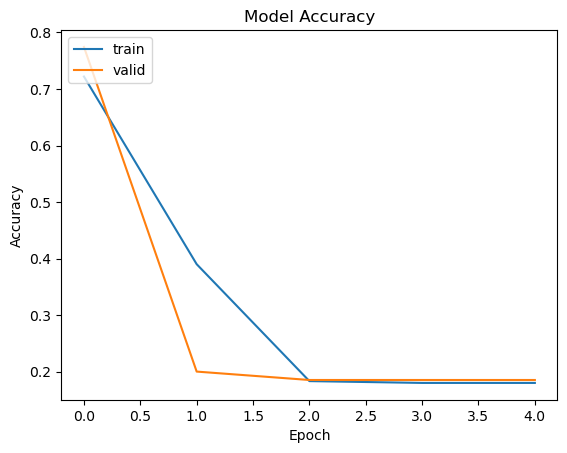

In [85]:
# summarize history for accuracy
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

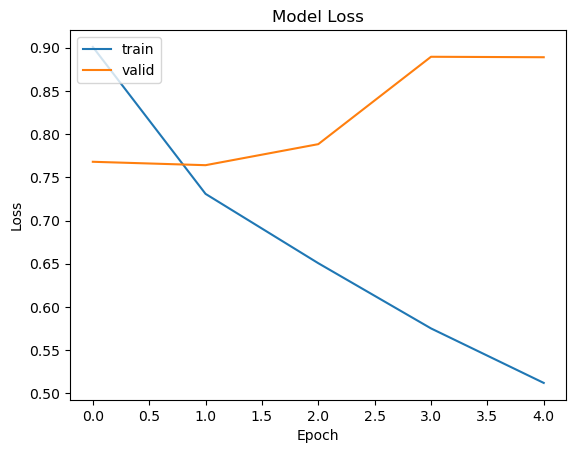

In [86]:
# summarize history for loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

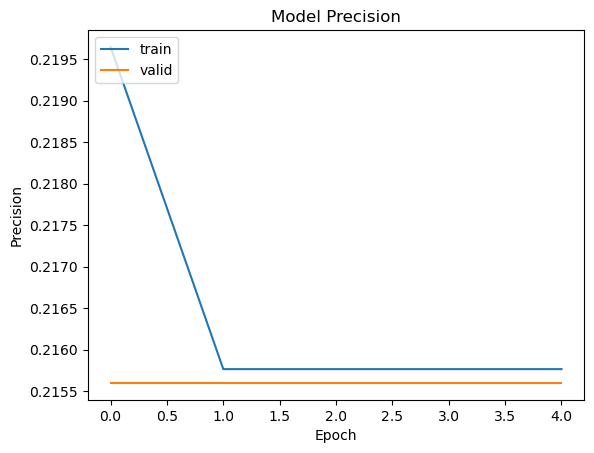

In [87]:
# summarize history for precision
plt.plot(history_3.history['precision'])
plt.plot(history_3.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [88]:
pred_labels_3 = model_3.predict([test_input_ids, test_attention_masks, test_token_type_ids])

110/110 [==============================] - 7s 51ms/step


In [89]:
pred_labels_3[:5]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)

In [90]:
model_3.evaluate([test_input_ids, test_attention_masks, test_token_type_ids], test_labels)

110/110 [==============================] - 7s 65ms/step - loss: 0.8437 - accuracy: 0.1875 - precision: 0.2134


[0.8437353372573853, 0.1875, 0.2133522778749466]

In [91]:
pred_labels_3 = [list(map(prob,i)) for i in pred_labels_3]

In [92]:
pred_labels_3[:5]

[[1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1]]

In [93]:
from sklearn.metrics import label_ranking_average_precision_score
lrap = label_ranking_average_precision_score(pred_labels_3, test_labels)
print("The Label Ranking Average Precision Score for the Test Set: ", lrap)

The Label Ranking Average Precision Score for the Test Set:  1.0


In [94]:
from sklearn.metrics import classification_report
target_names = train_data_new.columns[1:]
print(classification_report(test_labels, pred_labels_3, target_names=target_names))

              precision    recall  f1-score   support

       anger       0.19      1.00      0.32       660
        fear       0.03      1.00      0.05        91
         joy       0.57      1.00      0.73      2022
     sadness       0.10      1.00      0.18       358
    surprise       0.18      1.00      0.30       624

   micro avg       0.21      1.00      0.35      3755
   macro avg       0.21      1.00      0.32      3755
weighted avg       0.38      1.00      0.52      3755
 samples avg       0.21      1.00      0.35      3755

